# Домашнее задание № 1 (NLP). Тематическое моделирование

Классификация по тональности

- В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.
- Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.
- Тексты хранятся в json-ах в массиве responses.

### Часть 1. Анализ текстов

- Посчитайте количество отзывов в разных городах и на разные банки
- Постройте гистограмы длин слов в символах и в словах
- Найдите 10 самых частых:
  - слов
  - слов без стоп-слов
  - лемм
  - существительных
- Постройте кривые Ципфа и Хипса
- Ответьте на следующие вопросы:
  - какое слово встречается чаще, "сотрудник" или "клиент"?
  - сколько раз встречается слова "мошенничество" и "доверие"?
- В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру tf-idf, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import json
import bz2
import regex
from collections import Counter

import nltk
from scipy import sparse
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
responses = []

with bz2.BZ2File('/content/drive/MyDrive/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:18, 1453.78it/s]


In [4]:
responses[0]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Жалоба',
 'num_comments': 0,
 'bank_license': 'лицензия № 2562',
 'author': 'uhnov1',
 'bank_name': 'Бинбанк',
 'datetime': '2015-06-08 12:50:54',
 'text': 'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удо

In [5]:
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [6]:
len(df['bank_name'].unique())

670

In [7]:
len(df['city'].unique())

5824

In [8]:
df.city.unique()

array(['г. Москва', 'г. Новосибирск', 'г. Ставрополь', ...,
       'г. Москва-Владимир', 'г. СПб.',
       'г. Краснодарский край, ст.Павловская'], dtype=object)

*Судя по всему, имеется значительное количество некорректно заполненных данных в графе "city". Чистку данных проводить не будем, т.к. задача данного д/з в ином.*

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [10]:
# для целей данной работы, с учетом дефицита оперативной памяти, удалим все записи с пропусками
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74710 entries, 14 to 138946
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                74710 non-null  object 
 1   rating_not_checked  74710 non-null  bool   
 2   title               74710 non-null  object 
 3   num_comments        74710 non-null  int64  
 4   bank_license        74710 non-null  object 
 5   author              74710 non-null  object 
 6   bank_name           74710 non-null  object 
 7   datetime            74710 non-null  object 
 8   text                74710 non-null  object 
 9   rating_grade        74710 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 5.8+ MB


In [11]:
# - Посчитайте количество отзывов в разных городах и на разные банки
df_banks_by_city = df.groupby(['bank_name', 'city']).count()['text'].sort_values(ascending=False)
df_banks_by_city

bank_name         city              
Сбербанк России   г. Москва             4627
Альфа-Банк        г. Москва             2041
Русский Стандарт  г. Москва             1645
ВТБ 24            г. Москва             1542
Сбербанк России   г. Санкт-Петербург    1383
                                        ... 
ОТП Банк          г. Ижевск                1
                  г. Йошкар-Ола            1
                  г. КРАСНОДАР             1
                  г. Кавказская            1
Ярославич         г. Ярославль             1
Name: text, Length: 11932, dtype: int64

In [12]:
del df_banks_by_city
del responses

import gc
gc.collect()

0

<Axes: >

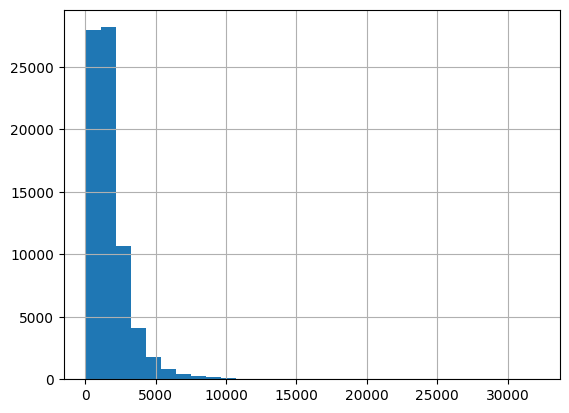

In [13]:
# - Постройте гистограмы длин слов в символах и в словах
df['len_text'] = df['text'].apply(len)
df['len_text'].hist(bins=30)

In [14]:
import re
regex = re.compile('[А-Яа-я]+')

def words_only(text, regex=regex):
    try:
        return ' '.join(regex.findall(text))
    except:
        return ''

In [15]:
df['words_text'] = (df['text'].str.lower()).apply(words_only)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,len_text,words_text
14,г. Москва,False,В Шоке,0,лицензия № 2673,yura1189,Тинькофф Банк,2015-06-05 13:52:40,"Также как и многие давний клиент банка, был до...",2.0,1649,также как и многие давний клиент банка был дов...
19,г. Москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0,2214,открыт вклад и счет в плюс к этому есть зарпла...
33,г. Ростов-на-Дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,Доброго времени! Вчера мне поступило смс-уведо...,1.0,2159,доброго времени вчера мне поступило смс уведом...
76,г. Санкт-Петербург,False,Нарушение договора банковского вклада,0,лицензия № 3006,qwarta45,АктивКапитал Банк,2015-06-06 23:42:39,"05.06.2015г. около 15 часов, пришел в указанны...",1.0,1262,г около часов пришел в указанный офис с намере...
85,г. Москва,False,"Невозможно оплатить отчисления на капремонт ""Т...",4,лицензия № 1481,721,Сбербанк России,2015-06-04 13:27:04,Для оплаты коммунальных платежей пользуюсь пла...,1.0,412,для оплаты коммунальных платежей пользуюсь пла...


<Axes: >

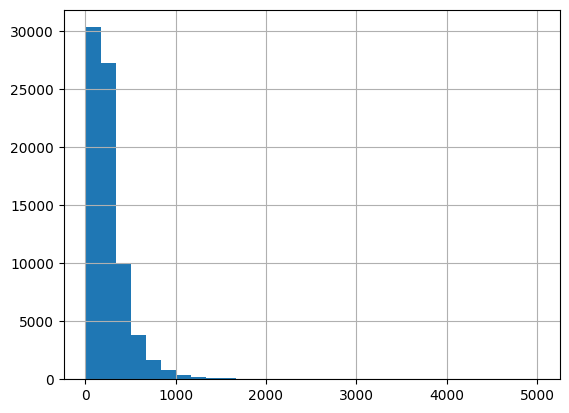

In [16]:
df['words_cnt'] = df['words_text'].apply(lambda x: len(x.split()))
df['words_cnt'].hist(bins=30)

In [17]:
# - Найдите 10 самых частых:
#   - слов
#   - слов без стоп-слов
#   - лемм
#   - существительных

cnt = Counter()
tokens = []
n_types = []
n_tokens = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    tokens = row['words_text'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

for i in cnt.most_common(10):
    print(i)

100%|██████████| 74710/74710 [03:39<00:00, 340.18it/s]

('в', 748789)
('и', 594700)
('не', 473300)
('на', 394752)
('что', 365487)
('я', 323819)
('с', 251617)
('по', 205276)
('мне', 185064)
('банка', 152600)


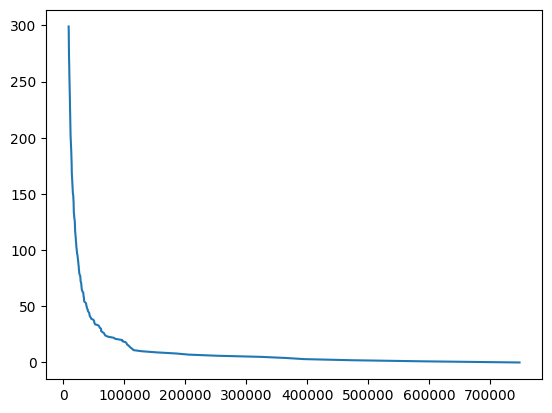

In [18]:
# - Постройте кривые Ципфа и Хипса

frequency_list = sorted(list(cnt.values()), reverse=True)

fig, ax = plt.subplots()
ax.plot(frequency_list[:300], range(300))
plt.show()

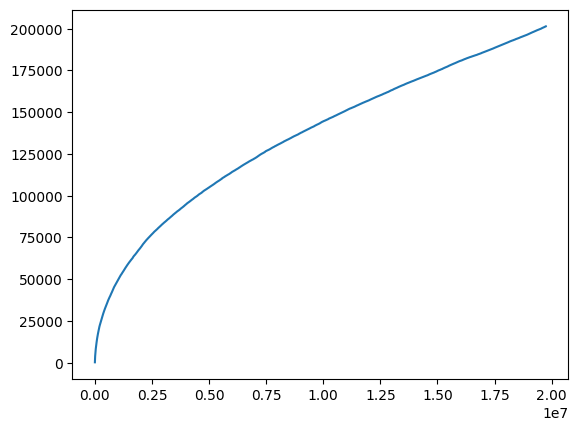

In [19]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_types)
plt.show()

In [20]:
# продолжение того же пункта - без стоп-слов

from nltk.corpus import stopwords
nltk.download('stopwords')
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также', 'тоже', 'т', 'д']
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return ' '.join([token for token in text.split() if not token in mystopwords])
    except:
        return ''

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
tqdm.pandas()

In [22]:
df['words_text_no_stops'] = df['words_text'].progress_apply(remove_stopwords)

100%|██████████| 74710/74710 [00:43<00:00, 1727.99it/s]


In [23]:
cnt_stop = Counter()
tokens_stop = []

for idx, row in tqdm(df.iterrows(), total = len(df)):
    tokens_stop = row['words_text_no_stops'].split()
    cnt_stop.update(tokens_stop)
for i in cnt_stop.most_common(10):
    print(i)

100%|██████████| 74710/74710 [00:12<00:00, 6011.21it/s]


('банка', 152600)
('банк', 114850)
('деньги', 72829)
('карту', 61763)
('карты', 57407)
('отделение', 42904)
('день', 42289)
('заявление', 41102)
('банке', 39943)
('кредит', 39937)


In [24]:
# посмотрим 100 наиболее частых слов (после исключения стоп-слов)
for i in cnt_stop.most_common(100):
    print(i)

('банка', 152600)
('банк', 114850)
('деньги', 72829)
('карту', 61763)
('карты', 57407)
('отделение', 42904)
('день', 42289)
('заявление', 41102)
('банке', 39943)
('кредит', 39937)
('время', 38192)
('очень', 37340)
('г', 36749)
('дней', 33541)
('счет', 32648)
('года', 29831)
('карта', 29525)
('почему', 29119)
('вопрос', 28290)
('ответ', 27609)
('смс', 26235)
('рублей', 25795)
('отделении', 25513)
('просто', 25176)
('сумму', 24649)
('минут', 24396)
('сегодня', 23998)
('офис', 23904)
('сказали', 23729)
('денег', 23319)
('счета', 21868)
('номер', 21708)
('банком', 21109)
('могу', 20958)
('нужно', 20909)
('руб', 20596)
('сотрудники', 20394)
('интернет', 20307)
('вклад', 19726)
('сотрудник', 19364)
('кредита', 19173)
('карте', 19071)
('который', 18923)
('е', 18887)
('девушка', 18821)
('банкомат', 18764)
('сбербанка', 18690)
('хотя', 18610)
('дня', 18195)
('мои', 17792)
('вс', 17611)
('клиентов', 17535)
('сразу', 17459)
('вообще', 17066)
('сотрудников', 16893)
('телефону', 16870)
('несколько'

In [25]:
# продолжение того же пункта - леммы

!pip install pymorphy2
from pymorphy2 import MorphAnalyzer
m = MorphAnalyzer()

In [26]:
def lemmatize(text, morph=m):
    try:
        return ' '.join([morph.parse(word)[0].normal_form for word in text.split()])
    except:
        return ' '

In [27]:
del n_types
del n_tokens
del mystopwords

import gc
gc.collect()

3612

In [28]:
df['lemma'] = df['words_text_no_stops'].progress_apply(lemmatize)

100%|██████████| 74710/74710 [43:49<00:00, 28.41it/s]


In [29]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,len_text,words_text,words_cnt,words_text_no_stops,lemma
14,г. Москва,False,В Шоке,0,лицензия № 2673,yura1189,Тинькофф Банк,2015-06-05 13:52:40,"Также как и многие давний клиент банка, был до...",2.0,1649,также как и многие давний клиент банка был дов...,237,многие давний клиент банка доволен высшей степ...,многие давний клиент банк довольный высокий ст...
19,г. Москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0,2214,открыт вклад и счет в плюс к этому есть зарпла...,342,открыт вклад счет плюс этому зарплатная карта ...,открыть вклад счёт плюс этот зарплатный карта ...
33,г. Ростов-на-Дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,Доброго времени! Вчера мне поступило смс-уведо...,1.0,2159,доброго времени вчера мне поступило смс уведом...,311,доброго времени вчера поступило смс уведомлени...,добрый время вчера поступить смс уведомление б...
76,г. Санкт-Петербург,False,Нарушение договора банковского вклада,0,лицензия № 3006,qwarta45,АктивКапитал Банк,2015-06-06 23:42:39,"05.06.2015г. около 15 часов, пришел в указанны...",1.0,1262,г около часов пришел в указанный офис с намере...,184,г около часов пришел указанный офис намерением...,г около час прийти указанный офис намерение по...
85,г. Москва,False,"Невозможно оплатить отчисления на капремонт ""Т...",4,лицензия № 1481,721,Сбербанк России,2015-06-04 13:27:04,Для оплаты коммунальных платежей пользуюсь пла...,1.0,412,для оплаты коммунальных платежей пользуюсь пла...,57,оплаты коммунальных платежей пользуюсь пластик...,оплата коммунальный платёж пользоваться пласти...


In [30]:
cnt_lemmas = Counter()
tokens_lemmas = []

for idx, row in tqdm(df.iterrows(), total = len(df)):
    tokens_lemmas = row['lemma'].split()
    cnt_lemmas.update(tokens_lemmas)

for i in cnt_lemmas.most_common(10):
    print(i)

100%|██████████| 74710/74710 [00:20<00:00, 3572.60it/s]


('банк', 363225)
('карта', 189965)
('деньга', 99900)
('день', 99059)
('отделение', 92701)
('мой', 88064)
('который', 83218)
('сотрудник', 79824)
('кредит', 77237)
('клиент', 76436)


In [31]:
# - Ответьте на следующие вопросы:
#   - какое слово встречается чаще, "сотрудник" или "клиент"?
#   - сколько раз встречается слова "мошенничество" и "доверие"?

# оценку будем проводить по леммам

employee_cnt = cnt_lemmas['сотрудник']
client_cnt = cnt_lemmas['клиент']

if client_cnt > employee_cnt:
      print(f'Cлово \"клиент\" встречается чаще, чем слово \"сотрудник\" ({client_cnt} / {employee_cnt} раз)')
else:
      print(f'Cлово \"сотрудник\" встречается чаще, чем слово \"клиент\" ({employee_cnt} / {client_cnt} раз)')

scam_cnt = cnt_lemmas['мошенничество']
print(f'Слово \"мошенничество\" встречается {scam_cnt} раз')

trust_cnt = cnt_lemmas['доверие']
print(f'Слово \"доверие\" встречается {trust_cnt} раз')

Cлово "сотрудник" встречается чаще, чем слово "клиент" (79824 / 76436 раз)
Слово "мошенничество" встречается 1193 раз
Слово "доверие" встречается 1103 раз


In [32]:
# сохранение промежуточного состояния датафрейма
# df.to_csv('df_v3.csv')
# df = pd.read_csv('df_v3.csv')

In [33]:
# В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5.
# Используйте меру tf-idf, для того, чтобы найти ключевые слова и биграмы
# для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

df['rating_grade'].fillna(0, inplace=True) # заполнение пропусков нулями

In [34]:
# запись токенов для каждого рейтинга от 0 до 5

tokens_for_every_rating = []

for rating in range(6):
    tokens = []
    subdf = df[df['rating_grade']==rating]['lemma']
    for i in range(len(subdf)):
        tokens += subdf.iloc[i].split()
    tokens_for_every_rating.append(tokens)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
# Ключевые слова (униграмы) отрицательных отзывов
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1))
tfidf_matrix = tfidf.fit_transform([' '.join(tokens) for tokens in tokens_for_every_rating])
features = tfidf.get_feature_names_out()
tfidf_ranking_neg_1g = []
dense = tfidf_matrix.todense()
text = dense[1].tolist()[0]
txt_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_txt_scores = sorted(txt_scores, key=lambda t: t[1]*(-1))
phrases = []
for phrase, score in [(features[word_id], score) for (word_id, score) in sorted_txt_scores][:10]:
    tfidf_ranking_neg_1g.append(phrase)

In [37]:
rankings = pd.DataFrame({'neg_1g': tfidf_ranking_neg_1g})
rankings

,neg_1g
0,банк
1,карта
2,деньга
3,день
4,мой
5,отделение
6,который
7,сотрудник
8,кредит
9,счёт


In [38]:
# Биграмы отрицательных отзывов
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2))
tfidf_matrix = tfidf.fit_transform([' '.join(tokens) for tokens in tokens_for_every_rating])
features = tfidf.get_feature_names_out()
tfidf_ranking_neg_2g = []
dense = tfidf_matrix.todense()
text = dense[1].tolist()[0]
txt_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_txt_scores = sorted(txt_scores, key=lambda t: t[1]*(-1))
phrases = []
for phrase, score in [(features[word_id], score) for (word_id, score) in sorted_txt_scores][:10]:
    tfidf_ranking_neg_2g.append(phrase)

In [39]:
rankings = pd.DataFrame({'neg_2g': tfidf_ranking_neg_2g})
rankings

,neg_2g
0,сотрудник банк
1,отделение банк
2,денежный средство
3,написать заявление
4,кредитный карта
5,горячий линия
6,колл центр
7,ваш банк
8,рабочий день
9,интернет банк


In [40]:
# Ключевые слова (униграмы) положительных отзывов
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1))
tfidf_matrix = tfidf.fit_transform([' '.join(tokens) for tokens in tokens_for_every_rating])
features = tfidf.get_feature_names_out()
tfidf_ranking_pos_1g = []
dense = tfidf_matrix.todense()
text = dense[5].tolist()[0]
txt_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_txt_scores = sorted(txt_scores, key=lambda t: t[1]*(-1))
phrases = []
for phrase, score in [(features[word_id], score) for (word_id, score) in sorted_txt_scores][:10]:
    tfidf_ranking_pos_1g.append(phrase)

In [41]:
rankings = pd.DataFrame({'pos_1g': tfidf_ranking_pos_1g})
rankings

,pos_1g
0,банк
1,карта
2,очень
3,клиент
4,день
5,сотрудник
6,кредит
7,который
8,отделение
9,вклад


In [42]:
# Биграмы положительных отзывов
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2))
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_for_every_rating])
features = tfidf.get_feature_names_out()
tfidf_ranking_pos_2g = []
dense = tfidf_matrix.todense()
text = dense[5].tolist()[0]
txt_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_txt_scores = sorted(txt_scores, key=lambda t: t[1]*(-1))
phrases = []
for phrase, score in [(features[word_id], score) for (word_id, score) in sorted_txt_scores][:10]:
    tfidf_ranking_pos_2g.append(phrase)

In [43]:
rankings = pd.DataFrame({'pos_2g': tfidf_ranking_pos_2g})
rankings

,pos_2g
0,интернет банк
1,сотрудник банк
2,другой банк
3,кредитный карта
4,клиент банк
5,отделение банк
6,являться клиент
7,следующий день
8,банк который
9,добрый день


Некоторые одинаковые биграммы имеются как в списке по позитивным отзывам, там и в топ-листе по негативным отзывам

In [44]:
del tfidf_matrix
del features
del dense
del text
del txt_scores
del sorted_txt_scores
del phrases
del rankings

gc.collect()

102

### Часть 2. Тематическое моделирование

- Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
- Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

In [45]:
import gensim.corpora as corpora
from gensim.models import ldamodel
import random

random.seed(23)

In [46]:
texts = [df['lemma'].iloc[i].split() for i in range(len(df))]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [47]:
lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [48]:
print('10 тематик:')
lda.show_topics(10)

10 тематик:


[(0,
  '0.050*"деньга" + 0.042*"банкомат" + 0.017*"день" + 0.017*"карта" + 0.017*"банк" + 0.016*"заявление" + 0.015*"сбербанк" + 0.015*"счёт" + 0.013*"мой" + 0.010*"средство"'),
 (1,
  '0.030*"банк" + 0.018*"звонить" + 0.016*"день" + 0.015*"кредит" + 0.013*"сказать" + 0.011*"говорить" + 0.010*"позвонить" + 0.008*"звонок" + 0.008*"заявление" + 0.008*"телефон"'),
 (2,
  '0.027*"банк" + 0.021*"вклад" + 0.014*"клиент" + 0.012*"очередь" + 0.012*"офис" + 0.009*"отделение" + 0.009*"минута" + 0.009*"время" + 0.009*"работать" + 0.008*"сотрудник"'),
 (3,
  '0.051*"банк" + 0.019*"мой" + 0.014*"договор" + 0.013*"сотрудник" + 0.012*"г" + 0.010*"клиент" + 0.009*"который" + 0.009*"ваш" + 0.009*"заявление" + 0.009*"кредитный"'),
 (4,
  '0.040*"банк" + 0.011*"очень" + 0.010*"карта" + 0.008*"клиент" + 0.007*"год" + 0.007*"который" + 0.007*"деньга" + 0.006*"свой" + 0.005*"интернет" + 0.005*"обслуживание"'),
 (5,
  '0.044*"отделение" + 0.012*"сказать" + 0.011*"карта" + 0.011*"сотрудник" + 0.010*"сбербанк"

In [49]:
lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=15, alpha='auto', eta='auto')

In [50]:
print('15 тематик:')
lda.show_topics(15)

15 тематик:


[(0,
  '0.039*"кредит" + 0.032*"банк" + 0.025*"документ" + 0.015*"заявка" + 0.011*"договор" + 0.009*"кредитный" + 0.009*"день" + 0.009*"менеджер" + 0.008*"страховка" + 0.008*"который"'),
 (1,
  '0.056*"деньга" + 0.055*"банкомат" + 0.025*"банк" + 0.021*"счёт" + 0.019*"карта" + 0.012*"сумма" + 0.011*"операция" + 0.010*"день" + 0.009*"средство" + 0.008*"снять"'),
 (2,
  '0.031*"банк" + 0.025*"комиссия" + 0.020*"перевод" + 0.017*"счёт" + 0.017*"рубль" + 0.015*"карта" + 0.013*"сумма" + 0.013*"операция" + 0.013*"курс" + 0.012*"тариф"'),
 (3,
  '0.103*"вклад" + 0.048*"банк" + 0.024*"открыть" + 0.023*"деньга" + 0.020*"процент" + 0.020*"депозит" + 0.017*"договор" + 0.012*"открытие" + 0.011*"счёт" + 0.011*"сумма"'),
 (4,
  '0.020*"касса" + 0.018*"сотрудник" + 0.018*"сказать" + 0.017*"кассир" + 0.012*"девушка" + 0.011*"такой" + 0.010*"офис" + 0.009*"клиент" + 0.009*"который" + 0.009*"отделение"'),
 (5,
  '0.048*"заявление" + 0.038*"день" + 0.025*"отделение" + 0.021*"написать" + 0.018*"деньга" + 0

In [51]:
lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, alpha='auto', eta='auto')

In [ ]:
print('5 тематик:')
lda.show_topics(5)

Выводы:
- доля объяснимых тем в рассмотренных трех наборах - в целом сопоставима
- в отдельных темах проскакивают названия конкретных крупных банков (Сбербанк, Альфа), это банки с наибольшим количеством отзывов в датасете

In [53]:
del texts
del dictionary
del corpus
del lda

gc.collect()

0

### Часть 3. Классификация текстов

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

- Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
- Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных n-грам.
- Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
  - 1-ый вариант: tf-idf преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
  - 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).

Используйте accuracy и F-measure для оценки качества классификации.

Эта часть задания может быть сделана с использованием sklearn.

In [54]:
# подготовка данных для классификации текстов
# предсказывать классы будем только по тексту (леммам), прочие признаки не используются
df2 = df.loc[df['rating_grade'].isin([1, 5])][['lemma', 'rating_grade']].reset_index(drop=True)
df2['rating_grade'] = df2['rating_grade'].apply(lambda x: 1 if x == 5 else 0)   # положительные - 1, отрицательные - 0

In [55]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50366 entries, 0 to 50365
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   lemma         50366 non-null  object
 1   rating_grade  50366 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 787.1+ KB


In [57]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [58]:
X_train, X_test, y_train, y_test = train_test_split(df2['lemma'], df2['rating_grade'], test_size=0.2, random_state=23)

In [59]:
X_train.shape

(40292,)

In [60]:
y_train.shape

(40292,)

In [61]:
X_test.shape

(10074,)

In [62]:
y_test.shape

(10074,)

--------------------
tf-idf + truncated SVD (униграммы - слова):
F1-score:	0.8512088635256132
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7921
           1       0.97      0.62      0.75      2153

    accuracy                           0.91     10074
   macro avg       0.94      0.81      0.85     10074
weighted avg       0.92      0.91      0.91     10074

Axes(0.125,0.11;0.62x0.77)


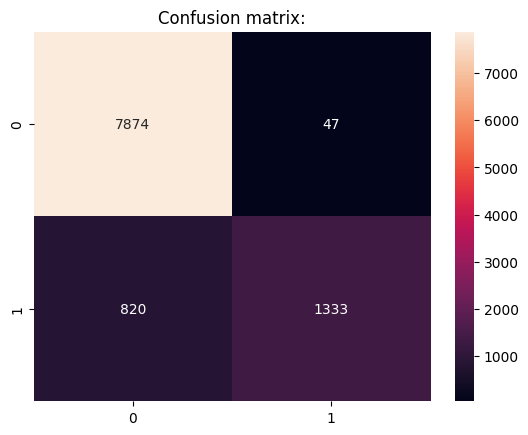

In [63]:
lemma_1 = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(1,1))),
    ('tfidf', TfidfTransformer()),
    ('tsvd', TruncatedSVD(n_components=100))
])

rf = RFC()
model_1 = rf.fit(lemma_1.fit_transform(X_train), y_train)
prediction = model_1.predict(lemma_1.transform(X_test))
print('--------------------')
print('tf-idf + truncated SVD (униграммы - слова):')
print(f'F1-score:\t{f1_score(y_test, prediction, average="macro")}')
print(classification_report(y_test, prediction))
labels = model_1.classes_
print(sns.heatmap(data=confusion_matrix(y_test, prediction), annot=True, fmt='d', xticklabels=labels, yticklabels=labels))
plt.title('Confusion matrix:')
plt.show()

**Tf-idf + truncated SVD (униграммы - слова):**
- F1-score: 0.85
- Высокая доля False Negative (FN) предсказаний

--------------------
tf-idf + truncated SVD (биграммы - слова):
F1-score:	0.8301437230559519
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7921
           1       0.95      0.58      0.72      2153

    accuracy                           0.90     10074
   macro avg       0.92      0.78      0.83     10074
weighted avg       0.91      0.90      0.89     10074

Axes(0.125,0.11;0.62x0.77)


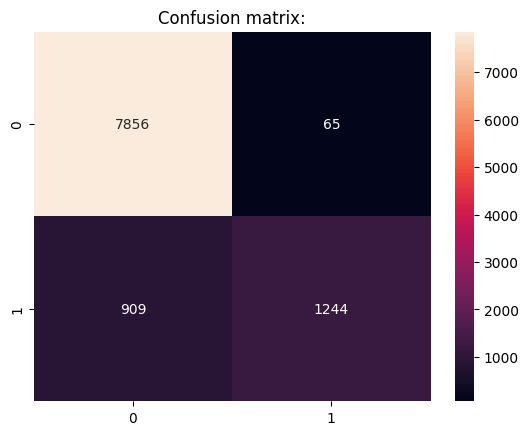

In [64]:
lemma_2 = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(2,2))),
    ('tfidf', TfidfTransformer()),
    ('tsvd', TruncatedSVD(n_components=100))
])

model_2 = rf.fit(lemma_2.fit_transform(X_train), y_train)
prediction = model_2.predict(lemma_2.transform(X_test))
print('--------------------')
print('tf-idf + truncated SVD (биграммы - слова):')
print(f'F1-score:\t{f1_score(y_test, prediction, average="macro")}')
print(classification_report(y_test, prediction))
labels = model_2.classes_
print(sns.heatmap(data=confusion_matrix(y_test, prediction), annot=True, fmt='d', xticklabels=labels, yticklabels=labels))
plt.title('Confusion matrix:')
plt.show()

**Tf-idf + truncated SVD (биграммы - слова):**
- F1-score: 0.83
- Высокая доля False Negative (FN) предсказаний

In [65]:
del model_1
del model_2
del lemma_1
del lemma_2
del prediction

gc.collect()

8650

In [ ]:
lemma_3 = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(3,3))),
    ('tfidf', TfidfTransformer()),
    ('tsvd', TruncatedSVD(n_components=100))
])

model_3 = rf.fit(lemma_3.fit_transform(X_train), y_train)
prediction = model_3.predict(lemma_3.transform(X_test))
print('--------------------')
print('tf-idf + truncated SVD (триграммы - слова):')
print(f'F1-score:\t{f1_score(y_test, prediction, average="macro")}')
print(classification_report(y_test, prediction))
labels = model_3.classes_
print(sns.heatmap(data=confusion_matrix(y_test, prediction), annot=True, fmt='d', xticklabels=labels, yticklabels=labels))
plt.title('Confusion matrix:')
plt.show()

**Tf-idf + truncated SVD (триграммы - слова):**
- многократно не удалось провести обучение модели из-за исчерпания оперативной памяти

In [ ]:
del model_3
del lemma_3
del prediction

gc.collect()

In [ ]:
lemma_4 = Pipeline([
    ('vect', CountVectorizer(analyzer='char', ngram_range=(4,7))),
    ('tfidf', TfidfTransformer()),
    ('tsvd', TruncatedSVD(n_components=100))
])

model_4 = rf.fit(lemma_4.fit_transform(X_train), y_train)
prediction = model_4.predict(lemma_4.transform(X_test))
print('--------------------')
print('tf-idf + truncated SVD (4-7-граммы - символы:')
print(f'F1-score:\t{f1_score(y_test, prediction, average="macro")}')
print(classification_report(y_test, prediction))
labels = model_4.classes_
print(sns.heatmap(data=confusion_matrix(y_test, prediction), annot=True, fmt='d', xticklabels=labels, yticklabels=labels))
plt.title('Confusion matrix:')
plt.show()

**Tf-idf + truncated SVD (4-7-граммы - символы):**
- многократно не удалось провести обучение модели из-за исчерпания оперативной памяти

In [ ]:
lemma_5 = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('lda', LatentDirichletAllocation(n_components=30, n_jobs=5))
])

model_5 = rf.fit(lemma_5.fit_transform(X_train), y_train)
prediction = model_5.predict(lemma_5.transform(X_test))
print('--------------------')
print('tf-idf + lda (1-2-граммы - слова):')
print(f'F1-score:\t{f1_score(y_test, prediction, average="macro")}')
print(classification_report(y_test, prediction))
labels = model_5.classes_
print(sns.heatmap(data=confusion_matrix(y_test, prediction), annot=True, fmt='d', xticklabels=labels, yticklabels=labels))
plt.title('Confusion matrix:')
plt.show()

**Tf-idf + LDA (1-2-граммы - слова):**
- многократно не удалось провести обучение модели из-за исчерпания оперативной памяти